In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
from postalcodes_ca import fsa_codes
import datetime
from scipy.optimize import curve_fit
import folium
from folium import GeoJson

Here I'm just trying to get the FSAs that are in each aggregated zone created by Jiaxin. For this I need to read the shapefiles he sent and do a spatial merge. 

First, all FSAs in Canada. 

<AxesSubplot:>

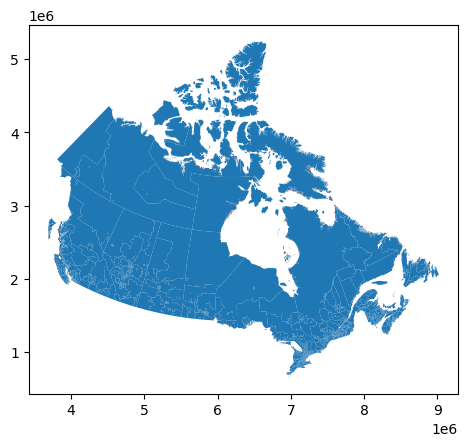

In [2]:
fsa_shapefile = gpd.read_file(r'C:\Users\mwendwa.kiko\Documents\Personal_Kiko\Old_UofT\Research\TraderCanada\AutoTrader_Data_code\fsa_shp_01_06_24\lfsa000b21a_e.shp')
fsa_shapefile.plot()

In [3]:
fsa_shapefile.head()

,CFSAUID,DGUID,PRUID,PRNAME,LANDAREA,geometry
0,A0A,2021A0011A0A,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,4136.6221,"MULTIPOLYGON (((8986398.603 2027249.146, 89863..."
1,A0B,2021A0011A0B,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,4152.6284,"MULTIPOLYGON (((8942820.023 2019517.649, 89428..."
2,A0C,2021A0011A0C,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,2733.4722,"MULTIPOLYGON (((8881604.920 2158976.151, 88816..."
3,A0E,2021A0011A0E,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,6365.8235,"MULTIPOLYGON (((8824262.857 1952006.689, 88242..."
4,A0G,2021A0011A0G,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,15499.6047,"MULTIPOLYGON (((8847567.966 2181504.514, 88475..."


In [4]:
output_dict = {}

Generating the dataframe with all aggregated FSAs for the whole country. 

In [5]:
# Define the top-level folder that contains a subfolder for each province
base_folder = '../AggregatedZones_Nationwide'

# List to store GeoDataFrames from each province
province_gdfs = []

# Loop over each subfolder (each representing a province)
for province in os.listdir(base_folder):
    province_folder = os.path.join(base_folder, province)
    if os.path.isdir(province_folder):
        # Read every shapefile in the province folder
        shapefiles = [gpd.read_file(os.path.join(province_folder, f))
                      for f in os.listdir(province_folder) if f.endswith('.shp')]
        if shapefiles:
            # Concatenate the shapefiles into a single GeoDataFrame for the province
            province_gdf = pd.concat(shapefiles, ignore_index=True)
            # Assign a unique ZoneID for each feature using the province name as prefix
            # e.g., "Manitoba_1", "all_zones_2", etc.
            province_gdf['ZoneID'] = province + '_' + (province_gdf.index + 1).astype(str)
            province_gdfs.append(province_gdf)

# Combine all provinces into one GeoDataFrame
canada_gdf = pd.concat(province_gdfs, ignore_index=True)

<AxesSubplot:>

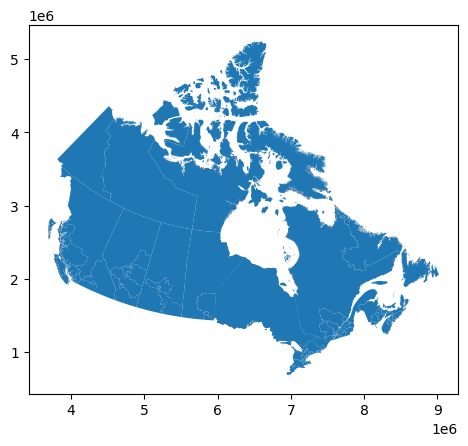

In [6]:
canada_gdf.plot()

In [7]:
canada_gdf.head()

,SUM_veh_ad,geometry,ZoneID,PRNAME,SUM_total_
0,143795.0,"POLYGON ((4803949.897 2177793.123, 4803988.163...",Alberta_1,NaN,NaN
1,142208.0,"POLYGON ((4541006.120 2118359.740, 4542508.151...",Alberta_2,NaN,NaN
2,143793.0,"POLYGON ((4721866.774 1923999.814, 4721366.451...",Alberta_3,NaN,NaN
3,143526.0,"POLYGON ((4669921.589 1945756.891, 4670597.257...",Alberta_4,NaN,NaN
4,147897.0,"POLYGON ((4686938.077 1922723.729, 4686960.583...",Alberta_5,NaN,NaN


In [8]:
# Dataframe with 3 columns: ZoneID, CFSAUID, proportion_in_zone
all_zones_df = pd.read_csv(r'../ZonalMappingModified3.csv')
all_zones_df

,ZoneID,CFSAUID,Province,MultiParts,proportion_in_zone,veh_adj,count,Should_prop_be_1,Prop_corrected
0,Alberta_1,T5S,Alberta,NO,0.000000,130425,1,1,1.000000
1,Alberta_1,T5T,Alberta,NO,0.000000,5924,1,1,1.000000
2,Alberta_1,T6M,Alberta,NO,0.000000,2833,1,1,1.000000
3,Alberta_1,T6R,Alberta,NO,0.000000,4613,1,1,1.000000
4,Alberta_10,T0K,Alberta,NO,0.000000,3758,1,1,1.000000
...,...,...,...,...,...,...,...,...,...
3811,Saskatchewan_5,S0N,Saskatchewan,YES,0.004989,11,2,0,0.004989
3812,Saskatchewan_5,S0N,Saskatchewan,YES,0.995011,2123,2,0,0.995011
3813,Saskatchewan_5,S0P,Saskatchewan,YES,0.346111,15,6,0,0.346111
3814,Saskatchewan_5,S0P,Saskatchewan,YES,0.546667,23,6,0,0.546667


In [9]:
all_zones_df['Province'].unique()

array(['Alberta', 'British Columbia', 'Manitoba', 'NovaScotia', 'Ontario',
       'Quebec', 'Saskatchewan'], dtype=object)

Maritimes missing: why? 

In [10]:
all_zones_df['CFSAUID'].nunique()

1442

In [11]:
all_zones_df.sort_values(by='proportion_in_zone', ascending=False).tail()

,ZoneID,CFSAUID,Province,MultiParts,proportion_in_zone,veh_adj,count,Should_prop_be_1,Prop_corrected
3141,ON_7,L8W,Ontario,NO,0.0,2648,1,1,1.0
3142,ON_7,L9A,Ontario,NO,0.0,2441,1,1,1.0
3143,ON_7,L9B,Ontario,NO,0.0,33319,1,1,1.0
3144,ON_7,L9C,Ontario,NO,0.0,21052,1,1,1.0
0,Alberta_1,T5S,Alberta,NO,0.0,130425,1,1,1.0


In [12]:
all_zones_df.loc[all_zones_df['proportion_in_zone'] != 1].shape[0]

3791

Sanity check of zones proportions: wrong, but not crazy

In [13]:
# List of CFSAUIDs that are not 1
prop_sum = (
    all_zones_df
      .groupby('CFSAUID')['Prop_corrected']
      .sum()
      .reset_index()
      .rename(columns={'Prop_corrected':'Sum_Prop'})
)
prop_sum

,CFSAUID,Sum_Prop
0,B0C,1.000000
1,B0E,1.000000
2,B0H,1.000000
3,B0J,1.000000
4,B0K,1.000000
...,...,...
1437,V9V,1.000000
1438,V9W,1.000000
1439,V9X,0.999806
1440,V9Y,0.999929


Reading file of transactions

In [14]:
df = pd.read_csv(r'C:\Users\mwendwa.kiko\Documents\Personal_Kiko\Old_UofT\Research\TraderCanada\AutoTrader_Data\univ-of-toronto\UnivOfToronto_Delistings_20240417132304.csv')

In [15]:
df.head()

,yr_month,Seller_FSA,Seller_Type,year,make,model,Fuel_Type,price_10k_bucket,Body_type,condition,delisted_ads
0,202012,T6B,Dealer,NaN,BMW,M,GasolineFuel,14,Sedan,New,1
1,202012,M5A,Dealer,NaN,Lexus,ES,Gas,0,Sedan,New,1
2,202010,L3R,Dealer,NaN,Lexus,ES,PremiumUnleaded,6,NaN,New,3
3,202011,V3H,Dealer,NaN,Lexus,IS,NaN,4,NaN,New,1
4,202012,M5A,Dealer,NaN,Lexus,IS,NaN,4,Sedan,New,1


In [16]:
df['year_grouped'] = df['year'].apply(lambda x: '1900-2005' if x <= 2005 else 
                                                    ('2006-2010' if x <= 2010 else ('2011-2015' if x <= 2016 else 
                                                                                    ('2017-2020' if x <= 2020 else 
                                                                                     '2021-2024'))))

In [17]:
df['yr_month_dtype'] = pd.to_datetime(df['yr_month'], format='%Y%m')
df['yr_month_dtype']

0          2020-12-01
1          2020-12-01
2          2020-10-01
3          2020-11-01
4          2020-12-01
              ...    
15175927   2024-02-01
15175928   2023-08-01
15175929   2023-11-01
15175930   2024-03-01
15175931   2024-02-01
Name: yr_month_dtype, Length: 15175932, dtype: datetime64[ns]

In [18]:
list_fsas_all = list(fsa_codes.keys())
len(list_fsas_all)

1651

In [19]:
df['Seller_FSA'] = df['Seller_FSA'].replace({'BH2': 'B2H', 'NOR': 'N0R'}).str.upper()

# Drop all rows with wrong fsas
df = df[df['Seller_FSA'].isin(list_fsas_all)]
df

,yr_month,Seller_FSA,Seller_Type,year,make,model,Fuel_Type,price_10k_bucket,Body_type,condition,delisted_ads,year_grouped,yr_month_dtype
0,202012,T6B,Dealer,NaN,BMW,M,GasolineFuel,14,Sedan,New,1,2021-2024,2020-12-01
1,202012,M5A,Dealer,NaN,Lexus,ES,Gas,0,Sedan,New,1,2021-2024,2020-12-01
2,202010,L3R,Dealer,NaN,Lexus,ES,PremiumUnleaded,6,NaN,New,3,2021-2024,2020-10-01
3,202011,V3H,Dealer,NaN,Lexus,IS,NaN,4,NaN,New,1,2021-2024,2020-11-01
4,202012,M5A,Dealer,NaN,Lexus,IS,NaN,4,Sedan,New,1,2021-2024,2020-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15175927,202402,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,8,2021-2024,2024-02-01
15175928,202308,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,2,2021-2024,2023-08-01
15175929,202311,B3K,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,1,2021-2024,2023-11-01
15175930,202403,P7B,Dealer,2025.0,Ram,1500,Gas,0,Truck,New,3,2021-2024,2024-03-01


In [20]:
df['Standard_fuel_types'] = df['Fuel_Type'].replace({'Gasoline': 'ICEV', 'Gas': 'ICEV', 'GasolineFuel': 'ICEV', 'Diesel': 'Diesel', 
                                                     'PremiumUnleaded': 'ICEV', 'RegularUnleaded': 'ICEV', 'GasolineHybrid': 'HEV',
                                                     'Flexible': 'Flexible', 'Electric': 'BEV', 'Gas/ElectricHybrid': 'HEV', 'DieselFuel': 'Diesel',
                                                     'Gasoline - Hybrid': 'HEV', 'PremiumUnleaded91Octane': 'ICEV', 'Compressed Natural Gas': 'AFV', 
                                                     'Gasoline-Hybrid': 'HEV', 'E85-Gasoline(FlexFuel)': 'Flexible', 'Gasoline Fuel': 'ICEV', 'CompressedNaturalGas': 'AFV',
                                                      'Propane': 'AFV', 'E85- Gasoline(Flex Fuel)': 'Flexible', 'Premium Unleaded 91 Octane': 'ICEV', 'Premium Unleaded': 'ICEV',
                                                      'GaseousFuelCompatible': 'AFV', 'Regular Unleaded': 'ICEV', 'Gaseous Fuel Compatible': 'AFV', 'FlexFuelCapability': 'Flexible',
                                                      'Diesel Fuel': 'Diesel', 'Flex Fuel Capability': 'Flexible', 'NaturalGas': 'AFV', 'Gas/Electric Hybrid': 'HEV', 'Gasoline Hybrid': 'HEV',
                                                      'E85 - Gasoline (Flex Fuel)': 'Flexible', 'Natural Gas': 'AFV'
                                                     })

Filtering out new only

In [21]:
df_new = df.loc[df['condition'] == 'New']
df_new

,yr_month,Seller_FSA,Seller_Type,year,make,model,Fuel_Type,price_10k_bucket,Body_type,condition,delisted_ads,year_grouped,yr_month_dtype,Standard_fuel_types
0,202012,T6B,Dealer,NaN,BMW,M,GasolineFuel,14,Sedan,New,1,2021-2024,2020-12-01,ICEV
1,202012,M5A,Dealer,NaN,Lexus,ES,Gas,0,Sedan,New,1,2021-2024,2020-12-01,ICEV
2,202010,L3R,Dealer,NaN,Lexus,ES,PremiumUnleaded,6,NaN,New,3,2021-2024,2020-10-01,ICEV
3,202011,V3H,Dealer,NaN,Lexus,IS,NaN,4,NaN,New,1,2021-2024,2020-11-01,NaN
4,202012,M5A,Dealer,NaN,Lexus,IS,NaN,4,Sedan,New,1,2021-2024,2020-12-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15175927,202402,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,8,2021-2024,2024-02-01,BEV
15175928,202308,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,2,2021-2024,2023-08-01,BEV
15175929,202311,B3K,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,1,2021-2024,2023-11-01,BEV
15175930,202403,P7B,Dealer,2025.0,Ram,1500,Gas,0,Truck,New,3,2021-2024,2024-03-01,ICEV


In [22]:
# Group by CMAUID, aggregating by count of EVs and total number of listings
df_grouped = df_new.groupby(['Seller_FSA', 'year_grouped', 'yr_month_dtype'])['Standard_fuel_types'].value_counts().unstack().fillna(0)
df_grouped['Total'] = df_grouped.sum(axis=1)
df_grouped['EV_percentage'] = df_grouped['BEV'] / df_grouped['Total']
df_grouped

Standard_fuel_types                     AFV  BEV  Diesel  Flexible  HEV  ICEV  \
Seller_FSA year_grouped yr_month_dtype                                          
A1B        2006-2010    2016-04-01      0.0  0.0     0.0       0.0  0.0   1.0   
           2011-2015    2016-01-01      0.0  0.0     0.0       0.0  0.0  13.0   
                        2016-02-01      0.0  0.0     0.0       0.0  0.0  19.0   
                        2016-03-01      0.0  0.0     0.0       0.0  0.0  14.0   
                        2016-04-01      0.0  0.0     0.0       0.0  0.0  12.0   
...                                     ...  ...     ...       ...  ...   ...   
Y1A        2021-2024    2023-11-01      0.0  1.0     0.0       0.0  0.0   8.0   
                        2023-12-01      0.0  1.0     0.0       0.0  0.0   3.0   
                        2024-01-01      0.0  2.0     1.0       0.0  2.0   8.0   
                        2024-02-01      0.0  3.0     1.0       0.0  0.0   9.0   
                        2024-03-01      0.0  1.0     1.0       0.0  1.0  12.0   

Standard_fuel_types                     Other  Total  EV_percentage  
Seller_FSA year_grouped yr_month_dtype                               
A1B        2006-2010    2016-04-01        0.0    1.0       0.000000  
           2011-2015    2016-01-01        0.0   13.0       0.000000  
                        2016-02-01        0.0   19.0       0.000000  
                        2016-03-01        0.0   14.0       0.000000  
                        2016-04-01        0.0   12.0       0.000000  
...                                       ...    ...            ...  
Y1A        2021-2024    2023-11-01        0.0    9.0       0.111111  
                        2023-12-01        0.0    4.0       0.250000  
                        2024-01-01        0.0   13.0       0.153846  
                        2024-02-01        0.0   13.0       0.230769  
                        2024-03-01        0.0   15.0       0.066667  

[76344 rows x 9 columns]

In [23]:
df_grouped = df_grouped.loc[:, ['BEV', 'Total']].reset_index()
df_grouped


Standard_fuel_types,Seller_FSA,year_grouped,yr_month_dtype,BEV,Total
0,A1B,2006-2010,2016-04-01,0.0,1.0
1,A1B,2011-2015,2016-01-01,0.0,13.0
2,A1B,2011-2015,2016-02-01,0.0,19.0
3,A1B,2011-2015,2016-03-01,0.0,14.0
4,A1B,2011-2015,2016-04-01,0.0,12.0
...,...,...,...,...,...
76339,Y1A,2021-2024,2023-11-01,1.0,9.0
76340,Y1A,2021-2024,2023-12-01,1.0,4.0
76341,Y1A,2021-2024,2024-01-01,2.0,13.0
76342,Y1A,2021-2024,2024-02-01,3.0,13.0


In [24]:
all_zones_df

,ZoneID,CFSAUID,Province,MultiParts,proportion_in_zone,veh_adj,count,Should_prop_be_1,Prop_corrected
0,Alberta_1,T5S,Alberta,NO,0.000000,130425,1,1,1.000000
1,Alberta_1,T5T,Alberta,NO,0.000000,5924,1,1,1.000000
2,Alberta_1,T6M,Alberta,NO,0.000000,2833,1,1,1.000000
3,Alberta_1,T6R,Alberta,NO,0.000000,4613,1,1,1.000000
4,Alberta_10,T0K,Alberta,NO,0.000000,3758,1,1,1.000000
...,...,...,...,...,...,...,...,...,...
3811,Saskatchewan_5,S0N,Saskatchewan,YES,0.004989,11,2,0,0.004989
3812,Saskatchewan_5,S0N,Saskatchewan,YES,0.995011,2123,2,0,0.995011
3813,Saskatchewan_5,S0P,Saskatchewan,YES,0.346111,15,6,0,0.346111
3814,Saskatchewan_5,S0P,Saskatchewan,YES,0.546667,23,6,0,0.546667


It checks out

In [25]:
# Merge with all_zones_df
pre_bass_input_df = all_zones_df.merge(df_grouped, left_on='CFSAUID', right_on='Seller_FSA', how='left', validate='many_to_many')
pre_bass_input_df

,ZoneID,CFSAUID,Province,MultiParts,proportion_in_zone,veh_adj,count,Should_prop_be_1,Prop_corrected,Seller_FSA,year_grouped,yr_month_dtype,BEV,Total
0,Alberta_1,T5S,Alberta,NO,0.000000,130425,1,1,1.000000,T5S,1900-2005,2018-08-01,0.0,1.0
1,Alberta_1,T5S,Alberta,NO,0.000000,130425,1,1,1.000000,T5S,1900-2005,2018-12-01,0.0,1.0
2,Alberta_1,T5S,Alberta,NO,0.000000,130425,1,1,1.000000,T5S,1900-2005,2019-02-01,0.0,166.0
3,Alberta_1,T5S,Alberta,NO,0.000000,130425,1,1,1.000000,T5S,1900-2005,2019-06-01,0.0,17.0
4,Alberta_1,T5S,Alberta,NO,0.000000,130425,1,1,1.000000,T5S,1900-2005,2019-07-01,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118325,Saskatchewan_5,S0N,Saskatchewan,YES,0.995011,2123,2,0,0.995011,S0N,2021-2024,2022-10-01,0.0,16.0
118326,Saskatchewan_5,S0N,Saskatchewan,YES,0.995011,2123,2,0,0.995011,S0N,2021-2024,2024-03-01,0.0,18.0
118327,Saskatchewan_5,S0P,Saskatchewan,YES,0.346111,15,6,0,0.346111,NaN,NaN,NaT,NaN,NaN
118328,Saskatchewan_5,S0P,Saskatchewan,YES,0.546667,23,6,0,0.546667,NaN,NaN,NaT,NaN,NaN


In [26]:
pre_bass_input_df['CFSAUID'].nunique()

1442

In [27]:
all_zones_df['CFSAUID'].nunique()

1442

In [28]:
pre_bass_input_df = pd.merge(pre_bass_input_df, prop_sum, left_on='CFSAUID', right_on='CFSAUID', how='left', validate='many_to_one')

pre_bass_input_df['BEV'] = pre_bass_input_df['BEV'] * pre_bass_input_df['Prop_corrected'] / pre_bass_input_df['Sum_Prop']
pre_bass_input_df['Total'] = pre_bass_input_df['Total'] * pre_bass_input_df['Prop_corrected'] / pre_bass_input_df['Sum_Prop']

pre_bass_input_df = pre_bass_input_df.groupby(['ZoneID', 'year_grouped', 'yr_month_dtype'])[['BEV', 'Total']].sum().reset_index()
pre_bass_input_df['EV_percentage'] = pre_bass_input_df['BEV'] / pre_bass_input_df['Total']
pre_bass_input_df['BEV'] = pre_bass_input_df['BEV'].round(0)
pre_bass_input_df

,ZoneID,year_grouped,yr_month_dtype,BEV,Total,EV_percentage
0,Alberta_1,1900-2005,2018-08-01,0.0,1.000000,0.000000
1,Alberta_1,1900-2005,2018-12-01,0.0,1.000000,0.000000
2,Alberta_1,1900-2005,2019-02-01,0.0,166.000000,0.000000
3,Alberta_1,1900-2005,2019-06-01,0.0,17.000000,0.000000
4,Alberta_1,1900-2005,2019-07-01,0.0,1.000000,0.000000
...,...,...,...,...,...,...
21137,Saskatchewan_5,2021-2024,2023-11-01,0.0,205.609129,0.000090
21138,Saskatchewan_5,2021-2024,2023-12-01,0.0,209.776200,0.000088
21139,Saskatchewan_5,2021-2024,2024-01-01,2.0,210.860514,0.009412
21140,Saskatchewan_5,2021-2024,2024-02-01,1.0,189.759131,0.005464


Sanity Check 

<AxesSubplot:xlabel='yr_month_dtype'>

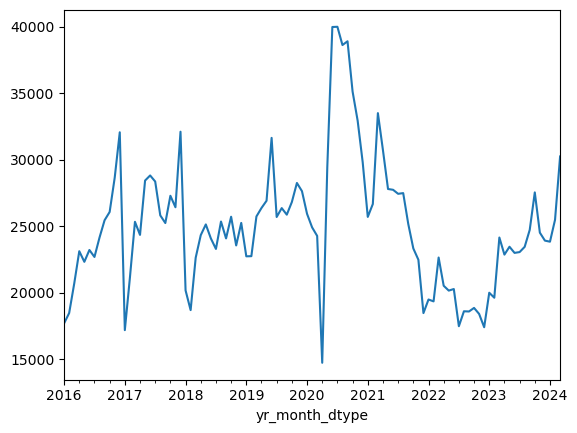

In [29]:
pre_bass_input_df.groupby('yr_month_dtype')['Total'].sum().plot()

<AxesSubplot:xlabel='yr_month_dtype'>

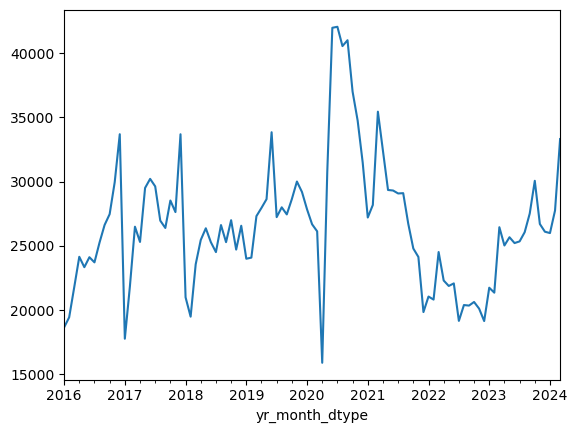

In [30]:
df.loc[df['condition'] == 'New'].groupby('yr_month_dtype').size().plot()

<AxesSubplot:xlabel='yr_month_dtype'>

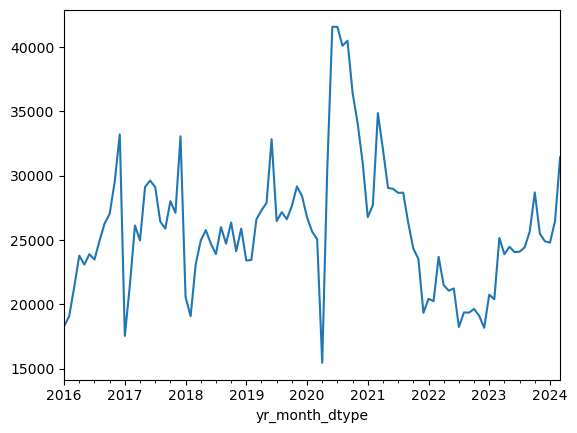

In [31]:
df_grouped.groupby('yr_month_dtype')['Total'].sum().plot()

In [32]:
pre_bass_input_df['Total'].sum()

2477147.0

In [33]:
(df.loc[df['condition'] == 'New', 'Standard_fuel_types'].notna()).sum()

2564399

In [34]:
df_grouped['Total'].sum()

2564399.0

So it checks out: I lost a few thousand obsvns because of fuel type being NA. And then a few more thousand because not all FSAs ended up being in zonal_mapping (so I guess Jiaxin threw away a few FSAs or something like that)

In [35]:
all_zones_2021_24 = pre_bass_input_df[pre_bass_input_df['year_grouped'] == '2021-2024']
all_zones_2017_20 = pre_bass_input_df[pre_bass_input_df['year_grouped'] == '2017-2020']

c:\Users\mwendwa.kiko\Anaconda3\envs\geopandasenv_kiko\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mwendwa.kiko\Anaconda3\envs\geopandasenv_kiko\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mwendwa.kiko\Anaconda3\envs\geopandasenv_kiko\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\mwendwa.kiko\Anaconda3\envs\geopandasenv_kiko\lib\site-p

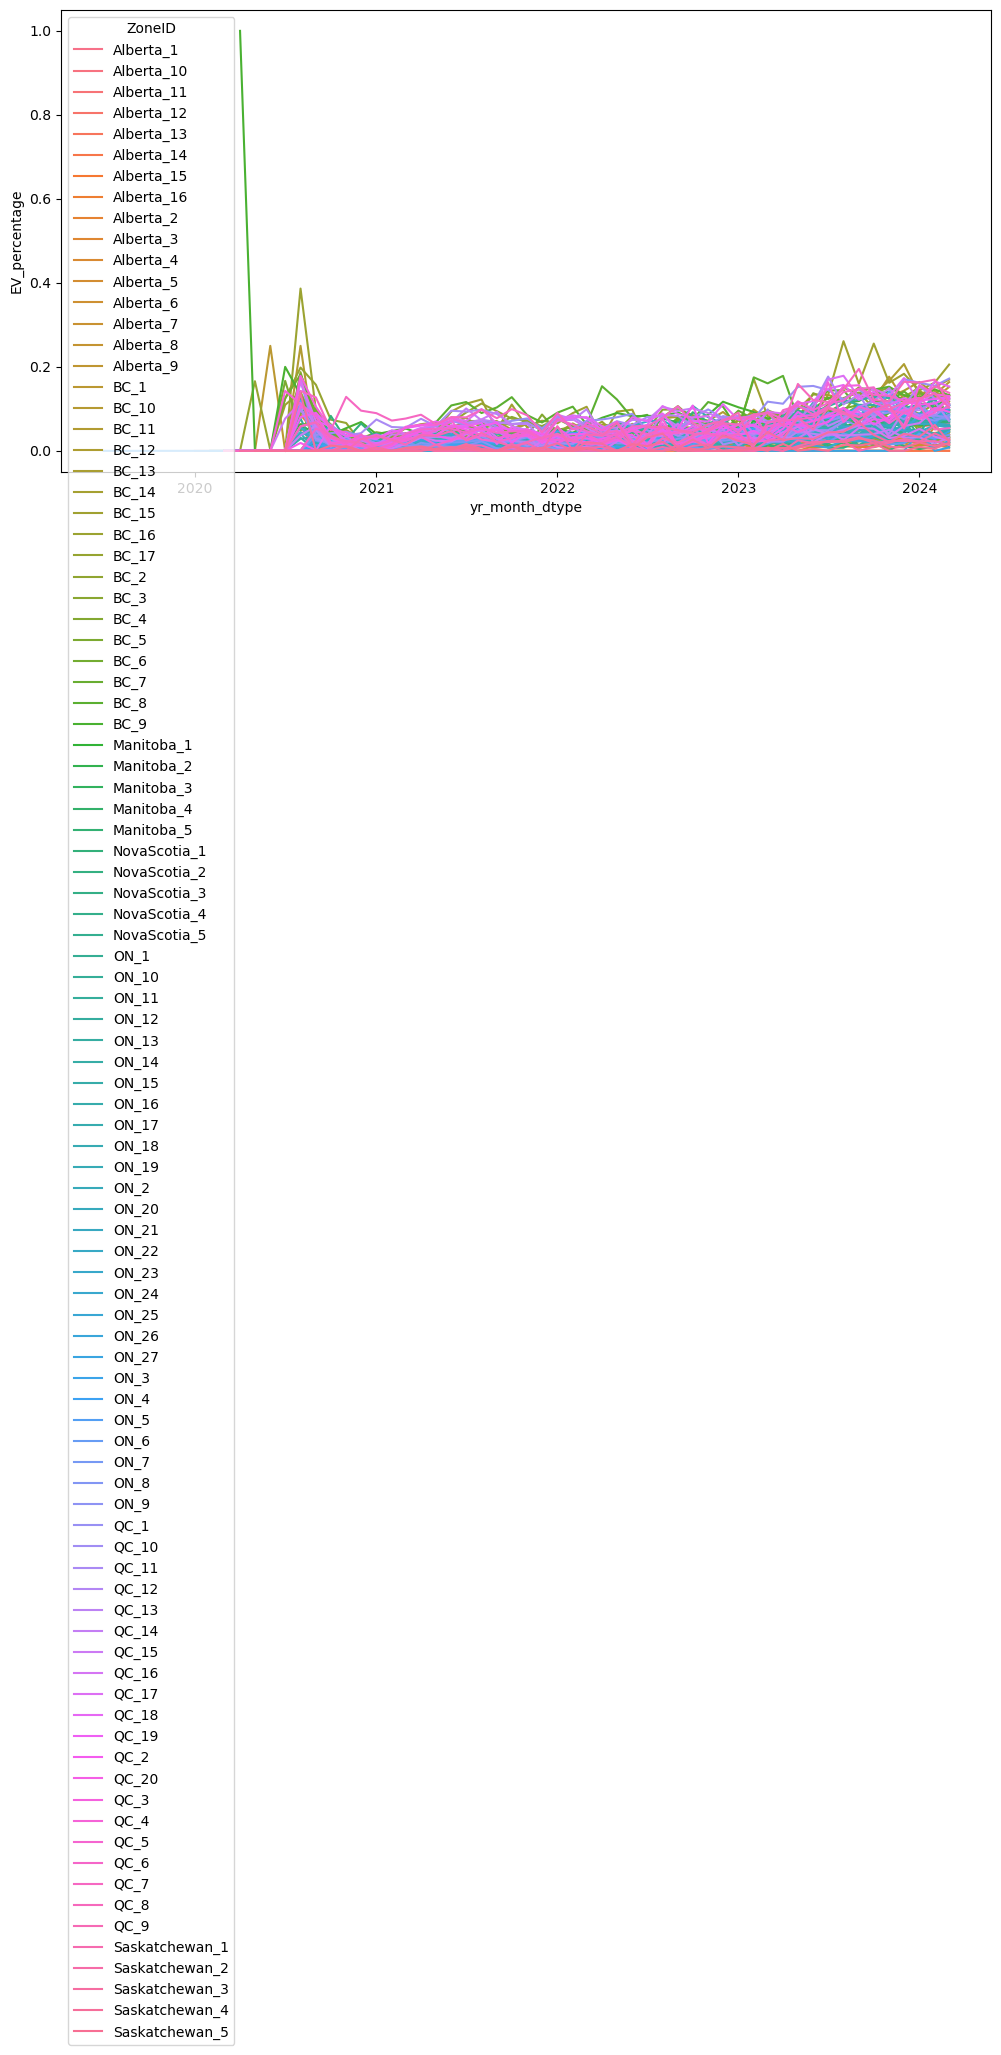

In [36]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=all_zones_2021_24, x='yr_month_dtype', y='EV_percentage', hue='ZoneID', ax=ax)
plt.show()

c:\Users\mwendwa.kiko\Anaconda3\envs\geopandasenv_kiko\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mwendwa.kiko\Anaconda3\envs\geopandasenv_kiko\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mwendwa.kiko\Anaconda3\envs\geopandasenv_kiko\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\mwendwa.kiko\Anaconda3\envs\geopandasenv_kiko\lib\site-p

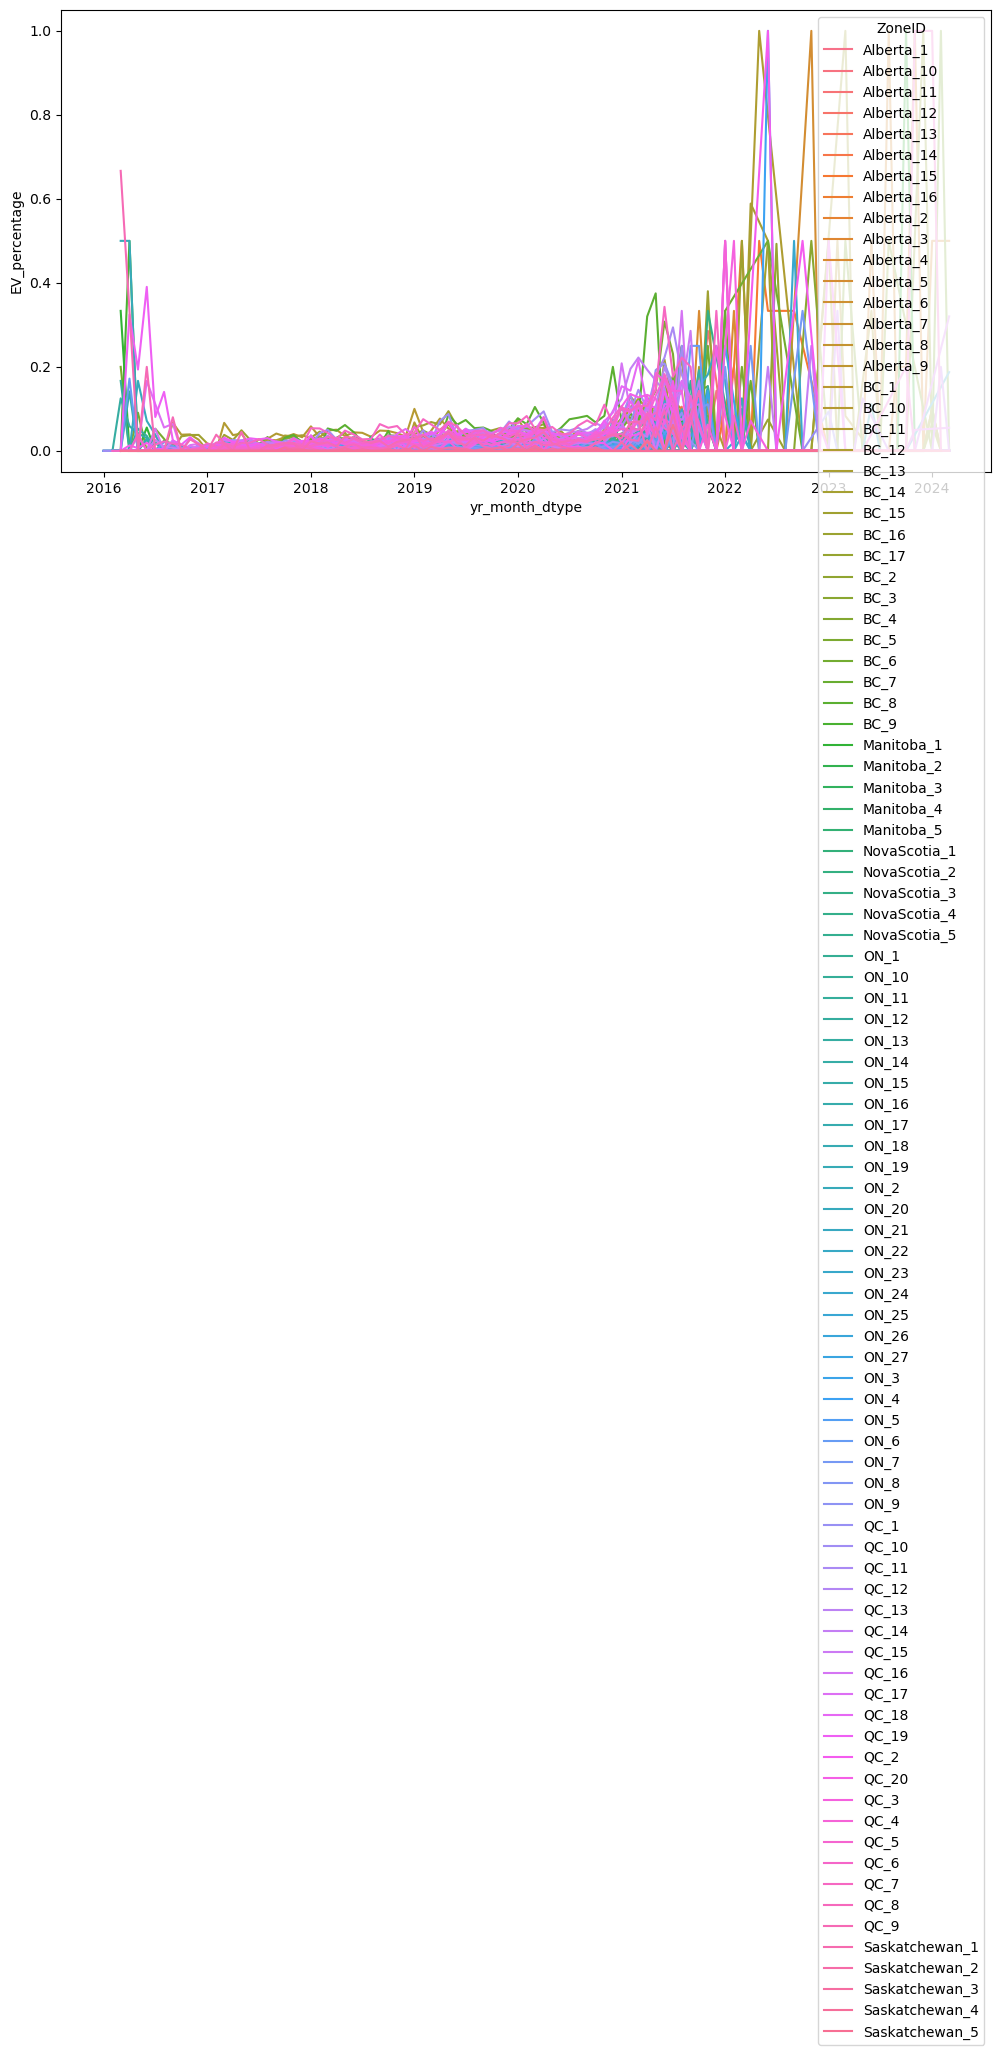

In [37]:
# Plot 2019-2021
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=all_zones_2017_20, x='yr_month_dtype', y='EV_percentage', hue='ZoneID', ax=ax)
plt.show()

In [38]:
# First, determining the market size
market_size_90_perc = pre_bass_input_df.groupby('ZoneID')['Total'].quantile(0.9)
market_size_90_perc

ZoneID
Alberta_1         335.600000
Alberta_10        375.685881
Alberta_11        341.500000
Alberta_12        309.761203
Alberta_13         51.939706
                     ...    
Saskatchewan_1    115.406297
Saskatchewan_2    249.645863
Saskatchewan_3    201.000000
Saskatchewan_4    278.394425
Saskatchewan_5    309.804261
Name: Total, Length: 95, dtype: float64

In [39]:
# 50th percentile monthly sales
market_size_50_perc = pre_bass_input_df.groupby('ZoneID')['Total'].quantile(0.5)
market_size_50_perc

ZoneID
Alberta_1          49.500000
Alberta_10         53.005118
Alberta_11        151.000000
Alberta_12         38.067851
Alberta_13         19.050302
                     ...    
Saskatchewan_1     45.504423
Saskatchewan_2     25.870050
Saskatchewan_3     96.000000
Saskatchewan_4    113.090971
Saskatchewan_5     23.037312
Name: Total, Length: 95, dtype: float64

In [40]:
market_size_90_perc.sort_values(ascending=False)

ZoneID
ON_14         622.567755
ON_20         588.292351
ON_16         556.740555
ON_11         523.118554
ON_9          502.500000
                 ...    
BC_8           87.600000
ON_25          67.574200
Alberta_14     51.939706
Alberta_13     51.939706
ON_27          44.100000
Name: Total, Length: 95, dtype: float64

In [41]:
market_size_50_perc.sort_values(ascending=False)

ZoneID
Alberta_2     277.000000
QC_20         158.602803
Alberta_5     153.500000
Alberta_11    151.000000
ON_23         150.019257
                 ...    
ON_20           7.000000
BC_14           6.219450
BC_7            6.000000
BC_17           5.021657
ON_22           5.000000
Name: Total, Length: 95, dtype: float64

In [48]:
market_size_90_perc.sum()

27599.321974089125

In [43]:
pre_bass_input_df.set_index(['ZoneID', 'year_grouped', 'yr_month_dtype'])['BEV']

ZoneID          year_grouped  yr_month_dtype
Alberta_1       1900-2005     2018-08-01        0.0
                              2018-12-01        0.0
                              2019-02-01        0.0
                              2019-06-01        0.0
                              2019-07-01        0.0
                                               ... 
Saskatchewan_5  2021-2024     2023-11-01        0.0
                              2023-12-01        0.0
                              2024-01-01        2.0
                              2024-02-01        1.0
                              2024-03-01        6.0
Name: BEV, Length: 21142, dtype: float64

In [46]:
bass_input = pre_bass_input_df.set_index(['ZoneID', 'year_grouped', 'yr_month_dtype'])['BEV']
bass_input = bass_input.unstack(level=1).fillna(0).reset_index()
bass_input

year_grouped,ZoneID,yr_month_dtype,1900-2005,2006-2010,2011-2015,2017-2020,2021-2024
0,Alberta_1,2016-01-01,0.0,0.0,0.0,0.0,0.0
1,Alberta_1,2016-02-01,0.0,0.0,0.0,0.0,0.0
2,Alberta_1,2016-03-01,0.0,0.0,0.0,0.0,0.0
3,Alberta_1,2016-04-01,0.0,0.0,0.0,0.0,0.0
4,Alberta_1,2016-05-01,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
9393,Saskatchewan_5,2023-11-01,0.0,0.0,0.0,0.0,0.0
9394,Saskatchewan_5,2023-12-01,0.0,0.0,0.0,0.0,0.0
9395,Saskatchewan_5,2024-01-01,0.0,0.0,0.0,0.0,2.0
9396,Saskatchewan_5,2024-02-01,0.0,0.0,0.0,0.0,1.0


Saving totals per zone and per period to use in calculating the market share

In [54]:
df_new_zones = df_new.merge(all_zones_df, left_on='Seller_FSA', right_on='CFSAUID', how='left', validate='many_to_many')
df_new_zones

,yr_month,Seller_FSA,Seller_Type,year,make,model,Fuel_Type,price_10k_bucket,Body_type,condition,...,Standard_fuel_types,ZoneID,CFSAUID,Province,MultiParts,proportion_in_zone,veh_adj,count,Should_prop_be_1,Prop_corrected
0,202012,T6B,Dealer,NaN,BMW,M,GasolineFuel,14,Sedan,New,...,ICEV,Alberta_7,T6B,Alberta,NO,0.000000,9672.0,1.0,1.0,1.000000
1,202012,M5A,Dealer,NaN,Lexus,ES,Gas,0,Sedan,New,...,ICEV,ON_15,M5A,Ontario,NO,0.000000,40363.0,1.0,1.0,1.000000
2,202010,L3R,Dealer,NaN,Lexus,ES,PremiumUnleaded,6,NaN,New,...,ICEV,ON_16,L3R,Ontario,YES,0.282373,22461.0,3.0,0.0,0.282373
3,202010,L3R,Dealer,NaN,Lexus,ES,PremiumUnleaded,6,NaN,New,...,ICEV,ON_16,L3R,Ontario,YES,0.712867,56704.0,3.0,0.0,0.712867
4,202010,L3R,Dealer,NaN,Lexus,ES,PremiumUnleaded,6,NaN,New,...,ICEV,ON_17,L3R,Ontario,YES,0.004715,375.0,3.0,0.0,0.004715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3814830,202402,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,...,BEV,QC_17,J8C,Quebec,NO,0.000000,14173.0,1.0,1.0,1.000000
3814831,202308,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,...,BEV,QC_17,J8C,Quebec,NO,0.000000,14173.0,1.0,1.0,1.000000
3814832,202311,B3K,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,...,BEV,NovaScotia_1,B3K,NovaScotia,YES,1.000000,62194.0,2.0,0.0,1.000000
3814833,202403,P7B,Dealer,2025.0,Ram,1500,Gas,0,Truck,New,...,ICEV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df_new_zones = pd.merge(df_new_zones, prop_sum, left_on='CFSAUID', right_on='CFSAUID', how='left', validate='many_to_one')

df_new_zones['Prop_corrected'] = df_new_zones['Prop_corrected'] / df_new_zones['Sum_Prop'] 

totals = df_new_zones.groupby(['ZoneID', 'yr_month_dtype'])['Prop_corrected'].sum().rename("Total_transactions").reset_index()
totals

,ZoneID,yr_month_dtype,Total_transactions
0,Alberta_1,2016-01-01,316.000000
1,Alberta_1,2016-02-01,388.000000
2,Alberta_1,2016-03-01,416.000000
3,Alberta_1,2016-04-01,387.000000
4,Alberta_1,2016-05-01,374.000000
...,...,...,...
9393,Saskatchewan_5,2023-11-01,211.677301
9394,Saskatchewan_5,2023-12-01,214.810285
9395,Saskatchewan_5,2024-01-01,211.928685
9396,Saskatchewan_5,2024-02-01,192.793217


In [95]:
totals['Total_transactions'].sum()

2542483.0000000005

In [97]:
df_new.shape[0]

2632207

So this seems approximately right. 

# Adding Teslas

In [56]:
statscan_registration_data_filtered_bev = pd.read_csv('statscan_registration_data_filtered_bev.csv')
statscan_registration_data_filtered_bev

,REF_DATE,GEO,DGUID,Fuel type,Vehicle type,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2017-01,Conception Bay South,2016A00051001485,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485219,4.2.1.1,NaN,..,NaN,NaN,0
1,2017-01,Conception Bay South,2016A00051001485,Battery electric,Passenger cars,Number of vehicles,Units,300,units,0,v1671256234,4.2.2.1,NaN,..,NaN,NaN,0
2,2017-01,Conception Bay South,2016A00051001485,Battery electric,Pickup trucks,Number of vehicles,Units,300,units,0,v1671256235,4.2.3.1,NaN,..,NaN,NaN,0
3,2017-01,Conception Bay South,2016A00051001485,Battery electric,Multi-purpose vehicles,Number of vehicles,Units,300,units,0,v1671256236,4.2.4.1,NaN,..,NaN,NaN,0
4,2017-01,Conception Bay South,2016A00051001485,Battery electric,Vans,Number of vehicles,Units,300,units,0,v1671256237,4.2.5.1,NaN,..,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878495,2025-07,"Kitikmeot, Unorganized",2016A00056208098,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277490560,5346.2.1.1,NaN,..,NaN,NaN,0
878496,2025-07,"Kitikmeot, Unorganized",2016A00056208098,Battery electric,Passenger cars,Number of vehicles,Units,300,units,0,v1671311586,5346.2.2.1,NaN,..,NaN,NaN,0
878497,2025-07,"Kitikmeot, Unorganized",2016A00056208098,Battery electric,Pickup trucks,Number of vehicles,Units,300,units,0,v1671311587,5346.2.3.1,NaN,..,NaN,NaN,0
878498,2025-07,"Kitikmeot, Unorganized",2016A00056208098,Battery electric,Multi-purpose vehicles,Number of vehicles,Units,300,units,0,v1671311588,5346.2.4.1,NaN,..,NaN,NaN,0


In [57]:
statscan_registration_data_filtered_bev['CSDUID'] = statscan_registration_data_filtered_bev['DGUID'].astype(str).str[9:].astype(int)
statscan_registration_data_filtered_bev['CSDUID']

0         1001485
1         1001485
2         1001485
3         1001485
4         1001485
           ...   
878495    6208098
878496    6208098
878497    6208098
878498    6208098
878499    6208098
Name: CSDUID, Length: 878500, dtype: int32

In [58]:
zone_csd_proportions = pd.read_csv('zone_csd_proportions_normalized.csv')
zone_csd_proportions

,ZoneID,CSDUID,prop_of_csd_in_zone_normalized
0,Alberta_1,4811034,1.058568e-05
1,Alberta_1,4811059,1.885483e-05
2,Alberta_1,4811061,1.621269e-01
3,Alberta_1,4811062,3.158524e-04
4,Alberta_1,4811804,5.876187e-04
...,...,...,...
6584,Saskatchewan_5,4812004,1.823177e-04
6585,Saskatchewan_5,4812038,2.096304e-06
6586,Saskatchewan_5,4816037,1.372567e-06
6587,Saskatchewan_5,6105097,3.595956e-01


In [59]:
statscan_registration_data_filtered_bev_merged = statscan_registration_data_filtered_bev.merge(
    zone_csd_proportions, on='CSDUID', how='inner'
)
statscan_registration_data_filtered_bev_merged = statscan_registration_data_filtered_bev_merged.loc[statscan_registration_data_filtered_bev_merged['Vehicle type'] == 'Total, vehicle type']
statscan_registration_data_filtered_bev_merged

,REF_DATE,GEO,DGUID,Fuel type,Vehicle type,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS,CSDUID,ZoneID,prop_of_csd_in_zone_normalized
0,2017-01,Conception Bay South,2016A00051001485,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485219,4.2.1.1,NaN,..,NaN,NaN,0,1001485,NewLab_2,1.000000e+00
5,2017-01,Portugal Cove-St. Philip's,2016A00051001504,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485220,5.2.1.1,NaN,..,NaN,NaN,0,1001504,NewLab_1,1.001798e-13
6,2017-01,Portugal Cove-St. Philip's,2016A00051001504,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485220,5.2.1.1,NaN,..,NaN,NaN,0,1001504,NewLab_2,1.000000e+00
15,2017-01,Pouch Cove,2016A00051001505,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485221,6.2.1.1,NaN,..,NaN,NaN,0,1001505,NewLab_2,1.000000e+00
20,2017-01,Flatrock,2016A00051001507,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485222,7.2.1.1,NaN,..,NaN,NaN,0,1001507,NewLab_2,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153042,2025-07,"Baffin, Unorganized",2016A00056204030,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277490544,5330.2.1.1,NaN,..,NaN,NaN,0,6204030,ON_19,4.124506e-01
1153043,2025-07,"Baffin, Unorganized",2016A00056204030,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277490544,5330.2.1.1,NaN,..,NaN,NaN,0,6204030,ON_20,4.124506e-01
1153044,2025-07,"Baffin, Unorganized",2016A00056204030,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277490544,5330.2.1.1,NaN,..,NaN,NaN,0,6204030,QC_8,3.068220e-02
1153065,2025-07,"Keewatin, Unorganized",2016A00056205033,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277490552,5338.2.1.1,NaN,..,NaN,NaN,0,6205033,Manitoba_5,1.000000e+00


In [60]:
statscan_registration_data_filtered_bev_merged['VALUE'].describe()

count    123669.000000
mean         11.896902
std          94.286905
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2492.000000
Name: VALUE, dtype: float64

In [61]:
statscan_registration_data_filtered_bev_merged['prop_of_csd_in_zone_normalized'].describe()

count    2.306150e+05
mean     7.470026e-01
std      4.002937e-01
min      2.694639e-27
25%      5.000000e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: prop_of_csd_in_zone_normalized, dtype: float64

In [62]:
statscan_registration_data_filtered_bev_merged['Scaled_CSD_transactions'] = (statscan_registration_data_filtered_bev_merged['VALUE'] * statscan_registration_data_filtered_bev_merged['prop_of_csd_in_zone_normalized']).fillna(0)
statscan_registration_data_filtered_bev_merged['Scaled_CSD_transactions']

0          0.0
5          0.0
6          0.0
15         0.0
20         0.0
          ... 
1153042    0.0
1153043    0.0
1153044    0.0
1153065    0.0
1153066    0.0
Name: Scaled_CSD_transactions, Length: 230615, dtype: float64

In [63]:
statscan_registration_data_filtered_bev_merged_grouped = statscan_registration_data_filtered_bev_merged.groupby(['REF_DATE', 'ZoneID'])['Scaled_CSD_transactions'].sum().unstack(fill_value=0)
statscan_registration_data_filtered_bev_merged_grouped

ZoneID,Alberta_1,Alberta_10,Alberta_11,Alberta_12,Alberta_13,Alberta_14,Alberta_15,Alberta_16,Alberta_2,Alberta_3,...,QC_5,QC_6,QC_7,QC_8,QC_9,Saskatchewan_1,Saskatchewan_2,Saskatchewan_3,Saskatchewan_4,Saskatchewan_5
REF_DATE,,,,,,,,,,,,,,,,,,,,,
2017-01,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.003319,0.001929,0.000000,0.000000,0.435674,0.564326,1.000000
2017-04,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.010581,0.004385,0.000000,0.000000,0.000000,0.000000,1.000000
2017-07,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.006060,0.004513,1.343336,0.656664,1.742695,2.257305,0.000000
2017-10,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.006795,0.004323,0.671668,1.328332,0.435674,0.564326,1.000000
2018-01,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.007962,0.003830,0.000000,0.000000,0.435674,1.564326,1.000000
2018-04,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.031481,0.015079,1.343336,0.656664,1.742695,5.257305,1.000003
2018-07,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.018675,0.009189,4.030105,2.969751,1.742695,4.257368,2.000080
2018-10,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.009622,0.005312,6.716681,5.283319,2.178369,2.821631,0.000000
2019-01,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.002170,0.001593,4.030008,2.969992,0.871348,4.128652,0.000000


In [64]:
# statscan_registration_data_filtered_bev_merged_grouped.sum().to_csv('Zone_BEV_Registrations_Scaled_CSD_transactions.csv')

Sanity check: Is the number of transactions after the merge the same as before. 

In [65]:
statscan_registration_data_filtered_bev_merged_grouped.sum().sum()

350349.99999999994

In [66]:
statscan_registration_data_filtered_bev.loc[statscan_registration_data_filtered_bev['Vehicle type'] == 'Total, vehicle type', 'VALUE'].sum()

350833.0

In [67]:
all_canada_data = pd.read_csv('Canada_transactions_databaseLoadingData.csv')
all_canada_data

,REF_DATE,GEO,DGUID,Fuel type,Vehicle type,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2017-01,Canada,2021A000011124,All fuel types,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1671330686,1.4.1.1,425031,NaN,NaN,NaN,0
1,2017-04,Canada,2021A000011124,All fuel types,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1671330686,1.4.1.1,610662,NaN,NaN,NaN,0
2,2017-07,Canada,2021A000011124,All fuel types,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1671330686,1.4.1.1,551572,NaN,NaN,NaN,0
3,2017-10,Canada,2021A000011124,All fuel types,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1671330686,1.4.1.1,450479,NaN,NaN,NaN,0
4,2018-01,Canada,2021A000011124,All fuel types,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1671330686,1.4.1.1,406109,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2024-07,Canada,2021A000011124,Other fuel types,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1671330706,1.8.1.1,3,NaN,NaN,NaN,0
276,2024-10,Canada,2021A000011124,Other fuel types,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1671330706,1.8.1.1,4,NaN,NaN,NaN,0
277,2025-01,Canada,2021A000011124,Other fuel types,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1671330706,1.8.1.1,8,NaN,NaN,NaN,0
278,2025-04,Canada,2021A000011124,Other fuel types,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1671330706,1.8.1.1,0,NaN,NaN,NaN,0


In [68]:
canada_bev = all_canada_data[(all_canada_data['Fuel type'] == 'Battery electric')& (all_canada_data['Vehicle type'] == 'Total, vehicle type')].reset_index(drop=True)
canada_bev.head()

,REF_DATE,GEO,DGUID,Fuel type,Vehicle type,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2017-01,Canada,2021A000011124,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485216,1.2.1.1,1664,NaN,NaN,NaN,0
1,2017-04,Canada,2021A000011124,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485216,1.2.1.1,2197,NaN,NaN,NaN,0
2,2017-07,Canada,2021A000011124,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485216,1.2.1.1,2401,NaN,NaN,NaN,0
3,2017-10,Canada,2021A000011124,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485216,1.2.1.1,2824,NaN,NaN,NaN,0
4,2018-01,Canada,2021A000011124,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485216,1.2.1.1,2639,NaN,NaN,NaN,0


In [69]:
canada_bev = canada_bev.rename(columns={'VALUE': 'Total_BEV_Transactions_Canada'}).set_index('REF_DATE').sort_values(by='REF_DATE')
canada_bev.head()

,GEO,DGUID,Fuel type,Vehicle type,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,Total_BEV_Transactions_Canada,STATUS,SYMBOL,TERMINATED,DECIMALS
REF_DATE,,,,,,,,,,,,,,,,
2017-01,Canada,2021A000011124,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485216,1.2.1.1,1664,NaN,NaN,NaN,0
2017-04,Canada,2021A000011124,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485216,1.2.1.1,2197,NaN,NaN,NaN,0
2017-07,Canada,2021A000011124,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485216,1.2.1.1,2401,NaN,NaN,NaN,0
2017-10,Canada,2021A000011124,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485216,1.2.1.1,2824,NaN,NaN,NaN,0
2018-01,Canada,2021A000011124,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1277485216,1.2.1.1,2639,NaN,NaN,NaN,0


In [70]:
statscan_registration_data_filtered_bev_merged_grouped = statscan_registration_data_filtered_bev_merged_grouped.merge(
    canada_bev['Total_BEV_Transactions_Canada'], left_index=True, right_index=True, how='left')
# statscan_registration_data_filtered_bev_merged_grouped.loc[:, :'Saskatchewan_5'] = statscan_registration_data_filtered_bev_merged_grouped.loc[:, :'Saskatchewan_5'].copy() / statscan_registration_data_filtered_bev_merged_grouped['Total_BEV_Transactions_Canada'].astype(float)
for col in statscan_registration_data_filtered_bev_merged_grouped.columns[:-1]:
    statscan_registration_data_filtered_bev_merged_grouped[col] = statscan_registration_data_filtered_bev_merged_grouped[col] / statscan_registration_data_filtered_bev_merged_grouped['Total_BEV_Transactions_Canada'].astype(float)
statscan_registration_data_filtered_bev_merged_grouped.head()

,Alberta_1,Alberta_10,Alberta_11,Alberta_12,Alberta_13,Alberta_14,Alberta_15,Alberta_16,Alberta_2,Alberta_3,...,QC_6,QC_7,QC_8,QC_9,Saskatchewan_1,Saskatchewan_2,Saskatchewan_3,Saskatchewan_4,Saskatchewan_5,Total_BEV_Transactions_Canada
REF_DATE,,,,,,,,,,,,,,,,,,,,,
2017-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000002,0.000001,0.000000,0.000000,0.000262,0.000339,0.000601,1664
2017-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000005,0.000002,0.000000,0.000000,0.000000,0.000000,0.000455,2197
2017-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000003,0.000002,0.000559,0.000273,0.000726,0.000940,0.000000,2401
2017-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000002,0.000002,0.000238,0.000470,0.000154,0.000200,0.000354,2824
2018-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000003,0.000001,0.000000,0.000000,0.000165,0.000593,0.000379,2639


In [71]:
statscan_registration_data_filtered_bev_merged_grouped.drop(columns=['Total_BEV_Transactions_Canada'], inplace=True)
# statscan_registration_data_filtered_bev_merged_grouped.to_csv('Zone_BEV_Registrations_Scaled_CSD_transactions_Normalized_by_Canada_Total.csv')

In [72]:
17501 / canada_bev['Total_BEV_Transactions_Canada'].sum()

0.02526450424491599

Sanity check: ON_10 has an average proportion of transactions of 0.027. It has 17501 transactions, corresponding to 0.025 of the Canada total

In [73]:
tesla_data_2019_23 = pd.read_csv('izev_data\\izev_tesla_purchases_2021-01_to_2024-03_2019-2023_izev_data.csv')
tesla_data_2019_23

,Incentive Request Date,Month and Year,Government of Canada Fiscal Year (FY),Calendar Year,Dealership Province/Territory,Dealership Postal Code,Purchase or Lease,Vehicle Year,Vehicle Make,Vehicle Model,Vehicle Make and Model,"Battery, Plug-in Hybrid, or Fuel Cell EV (BEV, PHEV or FCEV)",BEV/PHEV/FCEV - Battery ≥ 15kWh or electric range ≥ 50km,Battery/Electric Range Criteria Pre/Since 2022-04-25,Eligible Incentive Amount (in dollars),Individual or Organization (Recipient),Recipient Province/Territory,Country
0,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
1,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
2,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
3,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
4,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25332,2023-03-29,March 2023,2022-23,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
25333,2023-03-29,March 2023,2022-23,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
25334,2023-03-29,March 2023,2022-23,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
25335,2023-03-29,March 2023,2022-23,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Organization,Ontario,Canada


In [74]:
tesla_data_2023_24 = pd.read_csv('izev_data\\izev_tesla_purchases_2021-01_to_2024-03_2021-2024_izev_data.csv')
tesla_data_2023_24

,Incentive Request Date,Month and Year,Government of Canada Fiscal Year (FY),Calendar Year,Dealership Province/Territory,Dealership Postal Code,Purchase or Lease,Vehicle Year,Vehicle Make,Vehicle Model,Vehicle Make and Model,"Battery, Plug-in Hybrid, or Fuel Cell EV (BEV, PHEV or FCEV)",BEV/PHEV/FCEV - Battery ≥ 15kWh or electric range ≥ 50km,Battery/Electric Range Criteria Pre/Since 2022-04-25,Eligible Incentive Amount (in dollars),Individual or Organization (Recipient),Recipient Province/Territory,Country
0,2023-04-06,April 2023,2023-24,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
1,2023-04-06,April 2023,2023-24,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
2,2023-04-06,April 2023,2023-24,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
3,2023-04-06,April 2023,2023-24,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
4,2023-04-06,April 2023,2023-24,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44333,2024-03-31,March 2024,2023-24,2024.0,British Columbia,V5L,Purchase,2024.0,Tesla,Model Y,Tesla Model Y,BEV,YES,BEV,"5,000",Individual,British Columbia,Canada
44334,2024-03-31,March 2024,2023-24,2024.0,British Columbia,V5L,Purchase,2024.0,Tesla,Model Y,Tesla Model Y,BEV,YES,BEV,"5,000",Individual,British Columbia,Canada
44335,2024-03-31,March 2024,2023-24,2024.0,British Columbia,V5L,Purchase,2024.0,Tesla,Model Y,Tesla Model Y,BEV,YES,BEV,"5,000",Individual,British Columbia,Canada
44336,2024-03-31,March 2024,2023-24,2024.0,British Columbia,V5L,Purchase,2024.0,Tesla,Model Y,Tesla Model Y,BEV,YES,BEV,"5,000",Individual,Ontario,Canada


In [75]:
tesla_data = pd.concat([tesla_data_2019_23, tesla_data_2023_24], ignore_index=True)
tesla_data

,Incentive Request Date,Month and Year,Government of Canada Fiscal Year (FY),Calendar Year,Dealership Province/Territory,Dealership Postal Code,Purchase or Lease,Vehicle Year,Vehicle Make,Vehicle Model,Vehicle Make and Model,"Battery, Plug-in Hybrid, or Fuel Cell EV (BEV, PHEV or FCEV)",BEV/PHEV/FCEV - Battery ≥ 15kWh or electric range ≥ 50km,Battery/Electric Range Criteria Pre/Since 2022-04-25,Eligible Incentive Amount (in dollars),Individual or Organization (Recipient),Recipient Province/Territory,Country
0,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
1,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
2,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
3,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
4,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69670,2024-03-31,March 2024,2023-24,2024.0,British Columbia,V5L,Purchase,2024.0,Tesla,Model Y,Tesla Model Y,BEV,YES,BEV,"5,000",Individual,British Columbia,Canada
69671,2024-03-31,March 2024,2023-24,2024.0,British Columbia,V5L,Purchase,2024.0,Tesla,Model Y,Tesla Model Y,BEV,YES,BEV,"5,000",Individual,British Columbia,Canada
69672,2024-03-31,March 2024,2023-24,2024.0,British Columbia,V5L,Purchase,2024.0,Tesla,Model Y,Tesla Model Y,BEV,YES,BEV,"5,000",Individual,British Columbia,Canada
69673,2024-03-31,March 2024,2023-24,2024.0,British Columbia,V5L,Purchase,2024.0,Tesla,Model Y,Tesla Model Y,BEV,YES,BEV,"5,000",Individual,Ontario,Canada


In [76]:
tesla_data['Incentive Request Date'] = pd.to_datetime(tesla_data['Incentive Request Date'], format='%Y-%m-%d') 
tesla_data['Incentive Request Date'].head()

0   2021-01-11
1   2021-01-11
2   2021-01-11
3   2021-01-11
4   2021-01-11
Name: Incentive Request Date, dtype: datetime64[ns]

In [77]:
# 3 month counts 
tesla_three_month_counts = tesla_data.set_index('Incentive Request Date').resample('3M').size()
tesla_three_month_counts

C:\Users\mwendwa.kiko\AppData\Local\Temp\ipykernel_22536\3726302277.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tesla_three_month_counts = tesla_data.set_index('Incentive Request Date').resample('3M').size()


Incentive Request Date
2021-01-31       11
2021-04-30     3033
2021-07-31     2608
2021-10-31     6475
2022-01-31      912
2022-04-30     5161
2022-07-31     1708
2022-10-31     3219
2023-01-31       24
2023-04-30     2900
2023-07-31     3462
2023-10-31    20036
2024-01-31    12057
2024-04-30     8069
Freq: 3ME, dtype: int64

In [78]:
# Index as year-month
tesla_three_month_counts.index = tesla_three_month_counts.index.to_period('M')
tesla_three_month_counts

Incentive Request Date
2021-01       11
2021-04     3033
2021-07     2608
2021-10     6475
2022-01      912
2022-04     5161
2022-07     1708
2022-10     3219
2023-01       24
2023-04     2900
2023-07     3462
2023-10    20036
2024-01    12057
2024-04     8069
Freq: M, dtype: int64

In [79]:
# statscan_registration_data_filtered_bev_merged_grouped index as year-month
statscan_registration_data_filtered_bev_merged_grouped.index = pd.to_datetime(statscan_registration_data_filtered_bev_merged_grouped.index).to_period('M')
statscan_registration_data_filtered_bev_merged_grouped.head()

,Alberta_1,Alberta_10,Alberta_11,Alberta_12,Alberta_13,Alberta_14,Alberta_15,Alberta_16,Alberta_2,Alberta_3,...,QC_5,QC_6,QC_7,QC_8,QC_9,Saskatchewan_1,Saskatchewan_2,Saskatchewan_3,Saskatchewan_4,Saskatchewan_5
REF_DATE,,,,,,,,,,,,,,,,,,,,,
2017-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000002,0.000001,0.000000,0.000000,0.000262,0.000339,0.000601
2017-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000005,0.000002,0.000000,0.000000,0.000000,0.000000,0.000455
2017-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000003,0.000002,0.000559,0.000273,0.000726,0.000940,0.000000
2017-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000002,0.000002,0.000238,0.000470,0.000154,0.000200,0.000354
2018-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000003,0.000001,0.000000,0.000000,0.000165,0.000593,0.000379


In [80]:
statscan_registration_data_filtered_bev_merged_grouped_teslas = statscan_registration_data_filtered_bev_merged_grouped.merge(
    tesla_three_month_counts.rename('Tesla_3M_Counts'), left_index=True, right_index=True, how='inner'
)
statscan_registration_data_filtered_bev_merged_grouped_teslas.head()

,Alberta_1,Alberta_10,Alberta_11,Alberta_12,Alberta_13,Alberta_14,Alberta_15,Alberta_16,Alberta_2,Alberta_3,...,QC_6,QC_7,QC_8,QC_9,Saskatchewan_1,Saskatchewan_2,Saskatchewan_3,Saskatchewan_4,Saskatchewan_5,Tesla_3M_Counts
2021-01,0.0,1.467407e-21,0.0,0.0,0.0,0.0,2.097518e-09,0.0,0.000000e+00,0.0,...,0.0,0.0,0.000002,5.416673e-07,0.002065,0.001447,0.000376,0.001035,0.000563,11
2021-04,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,...,0.0,0.0,0.000002,9.595872e-07,0.001002,0.000903,0.000455,0.001081,0.000369,3033
2021-07,0.0,6.308750e-05,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,...,0.0,0.0,0.000002,8.613806e-07,0.001383,0.001078,0.000632,0.001260,0.000820,2608
2021-10,0.0,2.785716e-10,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2.194727e-11,0.0,...,0.0,0.0,0.000002,1.112601e-06,0.001710,0.001308,0.000856,0.001741,0.000632,6475
2022-01,0.0,2.014113e-10,0.0,0.0,0.0,0.0,0.000000e+00,0.0,1.586820e-11,0.0,...,0.0,0.0,0.000002,9.217455e-07,0.000815,0.000809,0.000553,0.001122,0.000558,912


In [81]:
for col in statscan_registration_data_filtered_bev_merged_grouped_teslas.columns[:-1]:
    statscan_registration_data_filtered_bev_merged_grouped_teslas[col] = statscan_registration_data_filtered_bev_merged_grouped_teslas[col] * statscan_registration_data_filtered_bev_merged_grouped_teslas['Tesla_3M_Counts'].astype(float)
statscan_registration_data_filtered_bev_merged_grouped_teslas.head()

,Alberta_1,Alberta_10,Alberta_11,Alberta_12,Alberta_13,Alberta_14,Alberta_15,Alberta_16,Alberta_2,Alberta_3,...,QC_6,QC_7,QC_8,QC_9,Saskatchewan_1,Saskatchewan_2,Saskatchewan_3,Saskatchewan_4,Saskatchewan_5,Tesla_3M_Counts
2021-01,0.0,1.614148e-20,0.0,0.0,0.0,0.0,2.307269e-08,0.0,0.000000e+00,0.0,...,0.0,0.0,0.000018,0.000006,0.022713,0.015918,0.004131,0.011386,0.006197,11
2021-04,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,...,0.0,0.0,0.006257,0.002910,3.037666,2.739450,1.380263,3.278735,1.118172,3033
2021-07,0.0,1.645322e-01,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,...,0.0,0.0,0.005095,0.002246,3.606430,2.810303,1.648695,3.287282,2.138932,2608
2021-10,0.0,1.803751e-06,0.0,0.0,0.0,0.0,0.000000e+00,0.0,1.421086e-07,0.0,...,0.0,0.0,0.014939,0.007204,11.071197,8.471448,5.544161,11.271622,4.090438,6475
2022-01,0.0,1.836871e-07,0.0,0.0,0.0,0.0,0.000000e+00,0.0,1.447179e-08,0.0,...,0.0,0.0,0.001967,0.000841,0.743028,0.738022,0.504104,1.023224,0.509105,912


In [82]:
statscan_registration_data_filtered_bev_merged_grouped_teslas.index

PeriodIndex(['2021-01', '2021-04', '2021-07', '2021-10', '2022-01', '2022-04',
             '2022-07', '2022-10', '2023-01', '2023-04', '2023-07', '2023-10',
             '2024-01', '2024-04'],
            dtype='period[M]')

In [84]:
def spread_3m_to_monthly(df_3m: pd.DataFrame) -> pd.DataFrame:
    """
    df_3m has a DatetimeIndex at 3-month intervals (e.g., 2021-01-01, 2021-04-01, ...).
    Each row is assumed to represent the total for the 3-month block starting at that date.

    Returns a monthly DataFrame where each block total is split equally across its 3 months.
    """
    df = df_3m.copy()
    df.index = pd.to_datetime(df.index.astype(str))

    # Split totals equally across the 3 months
    df = df / 3.0

    # Create monthly index covering the full span (month starts)
    monthly_idx = pd.date_range(df.index.min(), df.index.max() + pd.DateOffset(months=2), freq="MS")

    # Reindex to monthly, forward-fill values within each 3-month block
    out = df.reindex(monthly_idx).ffill()

    return out

statscan_registration_data_filtered_bev_merged_grouped_teslas_monthly = spread_3m_to_monthly(statscan_registration_data_filtered_bev_merged_grouped_teslas)
statscan_registration_data_filtered_bev_merged_grouped_teslas_monthly.tail(12)

,Alberta_1,Alberta_10,Alberta_11,Alberta_12,Alberta_13,Alberta_14,Alberta_15,Alberta_16,Alberta_2,Alberta_3,...,QC_6,QC_7,QC_8,QC_9,Saskatchewan_1,Saskatchewan_2,Saskatchewan_3,Saskatchewan_4,Saskatchewan_5,Tesla_3M_Counts
2023-07-01,0.0,5.697165e-07,0.0,0.0,0.0,0.000000e+00,0.0,0.0,5.763972e-07,0.0,...,0.0,0.0,0.001701,0.000901,1.056205,1.026960,0.884608,1.831434,0.527393,1154.000000
2023-08-01,0.0,5.697165e-07,0.0,0.0,0.0,0.000000e+00,0.0,0.0,5.763972e-07,0.0,...,0.0,0.0,0.001701,0.000901,1.056205,1.026960,0.884608,1.831434,0.527393,1154.000000
2023-09-01,0.0,5.697165e-07,0.0,0.0,0.0,0.000000e+00,0.0,0.0,5.763972e-07,0.0,...,0.0,0.0,0.001701,0.000901,1.056205,1.026960,0.884608,1.831434,0.527393,1154.000000
2023-10-01,0.0,1.561083e-18,0.0,0.0,0.0,0.000000e+00,0.0,0.0,3.488419e-06,0.0,...,0.0,0.0,0.012261,0.005558,5.558889,5.112837,2.978517,5.358769,3.001423,6678.666667
2023-11-01,0.0,1.561083e-18,0.0,0.0,0.0,0.000000e+00,0.0,0.0,3.488419e-06,0.0,...,0.0,0.0,0.012261,0.005558,5.558889,5.112837,2.978517,5.358769,3.001423,6678.666667
2023-12-01,0.0,1.561083e-18,0.0,0.0,0.0,0.000000e+00,0.0,0.0,3.488419e-06,0.0,...,0.0,0.0,0.012261,0.005558,5.558889,5.112837,2.978517,5.358769,3.001423,6678.666667
2024-01-01,0.0,1.783091e-06,0.0,0.0,0.0,2.556239e-08,0.0,0.0,2.323976e-06,0.0,...,0.0,0.0,0.005723,0.003553,3.867732,3.095995,1.859510,3.756456,2.134168,4019.000000
2024-02-01,0.0,1.783091e-06,0.0,0.0,0.0,2.556239e-08,0.0,0.0,2.323976e-06,0.0,...,0.0,0.0,0.005723,0.003553,3.867732,3.095995,1.859510,3.756456,2.134168,4019.000000
2024-03-01,0.0,1.783091e-06,0.0,0.0,0.0,2.556239e-08,0.0,0.0,2.323976e-06,0.0,...,0.0,0.0,0.005723,0.003553,3.867732,3.095995,1.859510,3.756456,2.134168,4019.000000
2024-04-01,0.0,5.539819e-02,0.0,0.0,0.0,1.260780e-08,0.0,0.0,1.076937e-06,0.0,...,0.0,0.0,0.003583,0.001910,2.702168,2.317992,1.230920,2.979312,1.849151,2689.666667


Sanity check: comparing the Tesla_3M_Counts column from this dataframe and the original one, we can see that they have been divided by 3. 

In [85]:
teslas = statscan_registration_data_filtered_bev_merged_grouped_teslas_monthly.copy().drop(columns=['Tesla_3M_Counts'])
# Drop rows after "2024-03-01"
teslas = teslas[teslas.index <= "2024-03-01"]
teslas.tail()

,Alberta_1,Alberta_10,Alberta_11,Alberta_12,Alberta_13,Alberta_14,Alberta_15,Alberta_16,Alberta_2,Alberta_3,...,QC_5,QC_6,QC_7,QC_8,QC_9,Saskatchewan_1,Saskatchewan_2,Saskatchewan_3,Saskatchewan_4,Saskatchewan_5
2023-11-01,0.0,1.561083e-18,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000003,0.0,...,0.0,0.0,0.0,0.012261,0.005558,5.558889,5.112837,2.978517,5.358769,3.001423
2023-12-01,0.0,1.561083e-18,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000003,0.0,...,0.0,0.0,0.0,0.012261,0.005558,5.558889,5.112837,2.978517,5.358769,3.001423
2024-01-01,0.0,1.783091e-06,0.0,0.0,0.0,2.556239e-08,0.0,0.0,0.000002,0.0,...,0.0,0.0,0.0,0.005723,0.003553,3.867732,3.095995,1.859510,3.756456,2.134168
2024-02-01,0.0,1.783091e-06,0.0,0.0,0.0,2.556239e-08,0.0,0.0,0.000002,0.0,...,0.0,0.0,0.0,0.005723,0.003553,3.867732,3.095995,1.859510,3.756456,2.134168
2024-03-01,0.0,1.783091e-06,0.0,0.0,0.0,2.556239e-08,0.0,0.0,0.000002,0.0,...,0.0,0.0,0.0,0.005723,0.003553,3.867732,3.095995,1.859510,3.756456,2.134168


In [86]:
teslas.stack()

2021-01-01  Alberta_1         0.000000e+00
            Alberta_10        5.380492e-21
            Alberta_11        0.000000e+00
            Alberta_12        0.000000e+00
            Alberta_13        0.000000e+00
                                  ...     
2024-03-01  Saskatchewan_1    3.867732e+00
            Saskatchewan_2    3.095995e+00
            Saskatchewan_3    1.859510e+00
            Saskatchewan_4    3.756456e+00
            Saskatchewan_5    2.134168e+00
Length: 4017, dtype: float64

In [87]:
# Pivot 
teslas_stacked = teslas.stack().reset_index().rename(columns={
    0: 'Normalized_BEV_Registrations_per_Tesla_3M_Counts',
    'level_0': 'yr_month_dtype',
    'level_1': 'ZoneID'})
teslas_stacked['Normalized_BEV_Registrations_per_Tesla_3M_Counts'] = np.where(
    teslas_stacked['Normalized_BEV_Registrations_per_Tesla_3M_Counts'] < 0.01, 0.0, teslas_stacked['Normalized_BEV_Registrations_per_Tesla_3M_Counts']
)
teslas_stacked.head()

,yr_month_dtype,ZoneID,Normalized_BEV_Registrations_per_Tesla_3M_Counts
0,2021-01-01,Alberta_1,0.0
1,2021-01-01,Alberta_10,0.0
2,2021-01-01,Alberta_11,0.0
3,2021-01-01,Alberta_12,0.0
4,2021-01-01,Alberta_13,0.0


## Adding to AutoTrader Data

In [88]:
bass_input = bass_input.merge(
    teslas_stacked,
    on=['ZoneID', 'yr_month_dtype'],
    how='left',
).fillna(0)
bass_input

,ZoneID,yr_month_dtype,1900-2005,2006-2010,2011-2015,2017-2020,2021-2024,Normalized_BEV_Registrations_per_Tesla_3M_Counts
0,Alberta_1,2016-01-01,0.0,0.0,0.0,0.0,0.0,0.000000
1,Alberta_1,2016-02-01,0.0,0.0,0.0,0.0,0.0,0.000000
2,Alberta_1,2016-03-01,0.0,0.0,0.0,0.0,0.0,0.000000
3,Alberta_1,2016-04-01,0.0,0.0,0.0,0.0,0.0,0.000000
4,Alberta_1,2016-05-01,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
9393,Saskatchewan_5,2023-11-01,0.0,0.0,0.0,0.0,0.0,3.001423
9394,Saskatchewan_5,2023-12-01,0.0,0.0,0.0,0.0,0.0,3.001423
9395,Saskatchewan_5,2024-01-01,0.0,0.0,0.0,0.0,2.0,2.134168
9396,Saskatchewan_5,2024-02-01,0.0,0.0,0.0,0.0,1.0,2.134168


In [89]:
bass_input['2021-2024'].describe(), (bass_input['2021-2024'] + bass_input['Normalized_BEV_Registrations_per_Tesla_3M_Counts']).describe()

(count    9398.000000
 mean        3.663865
 std         7.428587
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         4.000000
 max        82.000000
 Name: 2021-2024, dtype: float64,
 count    9398.000000
 mean        7.202341
 std        17.853738
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         6.264867
 max       224.575283
 dtype: float64)

In [90]:
bass_input['2021-2024'] = np.round(bass_input['2021-2024'] + bass_input['Normalized_BEV_Registrations_per_Tesla_3M_Counts'])
bass_input['2021-2024'].describe()

count    9398.000000
mean        7.198553
std        17.852032
min         0.000000
25%         0.000000
50%         0.000000
75%         6.000000
max       225.000000
Name: 2021-2024, dtype: float64

In [91]:
bass_input['months_passed_01_2017'] = (bass_input['yr_month_dtype'] - datetime.datetime(2017, 1, 1)) / np.timedelta64(1, 'W') / 4.345
bass_input['months_passed_01_2021'] = (bass_input['yr_month_dtype'] - datetime.datetime(2021, 1, 1)) / np.timedelta64(1, 'W') / 4.345
bass_input = bass_input.set_index('yr_month_dtype')
bass_input

,ZoneID,1900-2005,2006-2010,2011-2015,2017-2020,2021-2024,Normalized_BEV_Registrations_per_Tesla_3M_Counts,months_passed_01_2017,months_passed_01_2021
yr_month_dtype,,,,,,,,,
2016-01-01,Alberta_1,0.0,0.0,0.0,0.0,0.0,0.000000,-12.033536,-60.069045
2016-02-01,Alberta_1,0.0,0.0,0.0,0.0,0.0,0.000000,-11.014302,-59.049811
2016-03-01,Alberta_1,0.0,0.0,0.0,0.0,0.0,0.000000,-10.060825,-58.096334
2016-04-01,Alberta_1,0.0,0.0,0.0,0.0,0.0,0.000000,-9.041591,-57.077100
2016-05-01,Alberta_1,0.0,0.0,0.0,0.0,0.0,0.000000,-8.055236,-56.090745
...,...,...,...,...,...,...,...,...,...
2023-11-01,Saskatchewan_5,0.0,0.0,0.0,0.0,3.0,3.001423,82.031892,33.996383
2023-12-01,Saskatchewan_5,0.0,0.0,0.0,0.0,3.0,3.001423,83.018248,34.982739
2024-01-01,Saskatchewan_5,0.0,0.0,0.0,0.0,4.0,2.134168,84.037482,36.001973


In [93]:
bass_input_save = bass_input.merge(totals, left_on=['ZoneID', 'yr_month_dtype'], right_on=['ZoneID', 'yr_month_dtype'], how='left'
                                   )
bass_input_save

,ZoneID,yr_month_dtype,1900-2005,2006-2010,2011-2015,2017-2020,2021-2024,Normalized_BEV_Registrations_per_Tesla_3M_Counts,months_passed_01_2017,months_passed_01_2021,Total_transactions
0,Alberta_1,2016-01-01,0.0,0.0,0.0,0.0,0.0,0.000000,-12.033536,-60.069045,316.000000
1,Alberta_1,2016-02-01,0.0,0.0,0.0,0.0,0.0,0.000000,-11.014302,-59.049811,388.000000
2,Alberta_1,2016-03-01,0.0,0.0,0.0,0.0,0.0,0.000000,-10.060825,-58.096334,416.000000
3,Alberta_1,2016-04-01,0.0,0.0,0.0,0.0,0.0,0.000000,-9.041591,-57.077100,387.000000
4,Alberta_1,2016-05-01,0.0,0.0,0.0,0.0,0.0,0.000000,-8.055236,-56.090745,374.000000
...,...,...,...,...,...,...,...,...,...,...,...
9393,Saskatchewan_5,2023-11-01,0.0,0.0,0.0,0.0,3.0,3.001423,82.031892,33.996383,211.677301
9394,Saskatchewan_5,2023-12-01,0.0,0.0,0.0,0.0,3.0,3.001423,83.018248,34.982739,214.810285
9395,Saskatchewan_5,2024-01-01,0.0,0.0,0.0,0.0,4.0,2.134168,84.037482,36.001973,211.928685
9396,Saskatchewan_5,2024-02-01,0.0,0.0,0.0,0.0,3.0,2.134168,85.056715,37.021207,192.793217


In [99]:
bass_input_save['2021-2024_share'] = bass_input_save['2021-2024'] / bass_input_save['Total_transactions']
bass_input_save['2021-2024_share'].describe()

count    9398.000000
mean        0.031389
std         0.085163
min         0.000000
25%         0.000000
50%         0.000000
75%         0.029851
max         2.088235
Name: 2021-2024_share, dtype: float64

In [101]:
# Rows with 5 highest '2021-2024_share'
bass_input_save.nlargest(10, '2021-2024_share')

,ZoneID,yr_month_dtype,1900-2005,2006-2010,2011-2015,2017-2020,2021-2024,Normalized_BEV_Registrations_per_Tesla_3M_Counts,months_passed_01_2017,months_passed_01_2021,Total_transactions,2021-2024_share
6225,ON_27,2023-11-01,0.0,0.0,0.0,0.0,71.0,71.469916,82.031892,33.996383,34.0,2.088235
6226,ON_27,2023-12-01,0.0,0.0,0.0,0.0,71.0,71.469916,83.018248,34.982739,35.0,2.028571
6224,ON_27,2023-10-01,0.0,0.0,0.0,0.0,71.0,71.469916,81.012658,32.977149,43.0,1.651163
1976,BC_12,2023-12-01,0.0,0.0,0.0,0.0,208.0,176.909116,83.018248,34.982739,178.0,1.168539
1975,BC_12,2023-11-01,0.0,0.0,0.0,0.0,204.0,176.909116,82.031892,33.996383,179.0,1.139665
4444,ON_10,2023-12-01,0.0,0.0,0.0,0.0,202.0,192.334153,83.018248,34.982739,195.0,1.035897
4443,ON_10,2023-11-01,0.0,0.0,0.0,0.0,198.0,192.334153,82.031892,33.996383,200.0,0.990000
3163,BC_8,2023-11-01,0.0,0.0,0.0,0.0,75.0,63.944024,82.031892,33.996383,80.0,0.937500
1952,BC_12,2021-12-01,0.0,0.0,0.0,0.0,84.0,80.632188,59.016932,10.981424,95.0,0.884211
1951,BC_12,2021-11-01,0.0,0.0,0.0,0.0,85.0,80.632188,58.030577,9.995068,99.0,0.858586


In [102]:
# For the sake of reasonable, I'll cap at 1
bass_input_save['2021-2024_share_capped'] = np.where(bass_input_save['2021-2024_share'] > 1, 1, bass_input_save['2021-2024_share'])
bass_input_save['2021-2024_share_capped'].describe()

count    9398.000000
mean        0.031058
std         0.079511
min         0.000000
25%         0.000000
50%         0.000000
75%         0.029851
max         1.000000
Name: 2021-2024_share_capped, dtype: float64

Saving files

In [103]:
bass_input_save.to_csv('bass_input_rev2_b.csv', index=False)

In [232]:
market_size_90_perc.to_csv('market_size_90_perc_correct_rev2.csv')
market_size_50_perc.to_csv('market_size_50_perc_correct_rev2.csv')

In [45]:
# market_sizes_all_zones_grouped.to_csv('market_sizes_all_zones_grouped.csv', index=False)

In [46]:
# market_sizes_beck_divided = market_sizes_all_zones_grouped.copy()
# market_sizes_beck_divided['Final_Market'] = market_sizes_beck_divided['Final_Market'] / 99
